# Copia: quickstart

## Preprocessing and exploration

We start with a single assemblage. We load the works:

In [1]:
import pandas as pd
df = pd.read_csv('../datasets/dum.csv', sep=';', header=None)
df.columns = 'work', 'signature'
df.head()

,work,signature
0,Aiol (1),"Leiden, UB, BPL 1049; Brussel, KB, IV 816"
1,Aiol (2),"Breda, Arch. Begijnhof, z.s."
2,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders geesten,"Gent, UB, 2749,6"
4,Alexanders geesten,"Leiden, UB, Ltk. 1196"


Use utility function to convert the list of works to abundance data:

In [2]:
from copia.utils import to_abundance, basic_stats
works = df['work']
abundance = to_abundance(works)
abundance

array([ 1,  1,  5,  2,  1,  2,  1,  1,  2,  2,  3,  3,  1,  1,  2,  1,  1,
        1,  1,  2,  1,  1,  1,  1,  1,  1,  4,  1,  1,  7,  1,  1,  3,  1,
       10,  1,  3,  2, 10,  4,  2,  1,  3,  6,  5,  2,  5,  2,  5,  1,  1,
        1,  1,  1,  2, 17,  2,  1,  1,  2,  1,  1,  1,  3,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1])

Print some basic stats about the assemblage:

In [3]:
basic_stats(abundance)

{'f1': 45, 'f2': 13, 'f3': 6, 'f4': 2, 'S': 75, 'n': 167}

Visualize the abundance data as a histogram, with (ranked) abundance counts for each individual species (to which we can optionally fit a Fisher log series as a trendline):

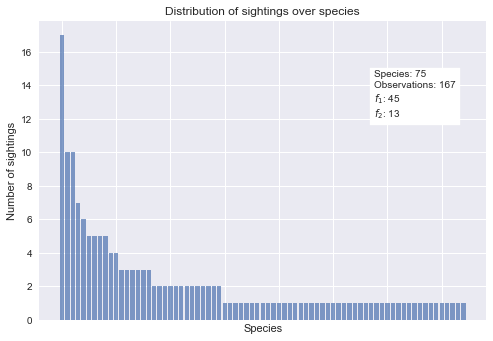

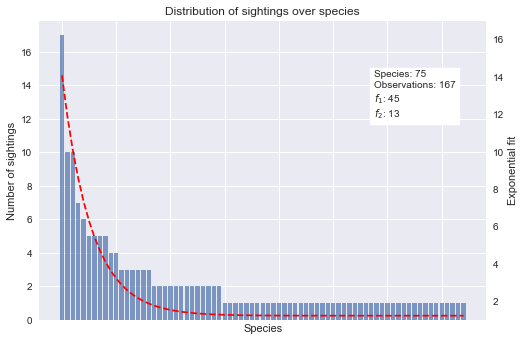

In [4]:
from copia.plot import abundance_counts
abundance_counts(abundance)
abundance_counts(abundance, trendline=True);

To save the last graph to a file:

In [5]:
import matplotlib.pyplot as plt
plt.savefig('../outputs/abundance_cnt.pdf')

<Figure size 576x396 with 0 Axes>

Alternatively, visualize the abundance counts per frequency category (an exponential trend line can be fitted to the resulting barplot):

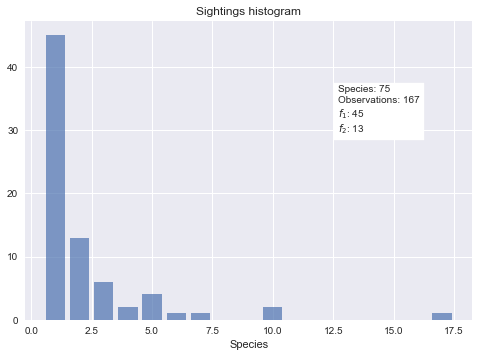

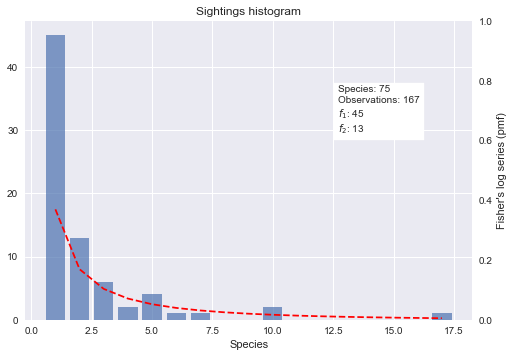

In [6]:
from copia.plot import abundance_histogram
abundance_histogram(abundance)
abundance_histogram(abundance, trendline=True)
plt.savefig('../outputs/abundance_hist.pdf')

## Species richness

### Basic species richness

Estimate unbiased diversity using one of the estimators in `copia.richness`. All of the estimators are available from a single entry point, `diversity()` (or they can be accessed directly):

In [7]:
from copia.richness import *
print(diversity(abundance, method='chao1'))
print(chao1(abundance))

152.41824044219254
152.41824044219254


By default, the estimators only return a single number, i.e. the estimate. Some estimators accept additional arguments that can be passed as `**kwargs` to `diversity()`, in which case a `dict` with the relevant fields will be returned:

In [8]:
print(jackknife(abundance, return_order=True))
print(diversity(abundance, method='jackknife', return_order=True))

{'richness': 177.0, 'order': 3}
{'richness': 177.0, 'order': 3}


A variety of estimators is included:

In [9]:
for m in ('chao1', 'ichao1', 'ace', 'jackknife', 'egghe_proot'):
    print(m, '->', diversity(abundance, method=m))

chao1 -> 152.41824044219254
ichao1 -> 171.54324044219254
ace -> 152.3244760991645
jackknife -> 177.0
egghe_proot -> 170.30024512537264


To obtain the *empirical* species richness or the population size, use:

In [10]:
print('species richness:', diversity(abundance, method='empirical'))
print('population size:', diversity(abundance, method='empirical', species=False))

species richness: 75
population size: 167


### Bootstrapped estimation

To obtain a lower and upper bound for the confidence interval on an estimate, it is common to apply a bootstrapped procedure. Set `CI=True` for this, so that a `dict` with the relevant keys (including the actual bootstrap values) is returned:

In [11]:
diversity(abundance, method='chao1', CI=True, n_iter=10)

100%|██████████| 10/10 [00:00<00:00, 22.01it/s]


{'richness': 152.41824044219254,
 'lci': 129.49835013622442,
 'uci': 186.9876138706603,
 'std': 18.055585124899757,
 'bootstrap': array([192.16631896, 136.56609085, 148.20424311, 138.79433565,
        169.14985189, 152.08393827, 127.44642541, 145.07583327,
        146.87599053, 167.81937648])}

For the Jackknife, the CI is calculated calculated analytically, so that no bootstrap values will be returned:

In [12]:
diversity(abundance, method='jackknife', CI=True)

{'richness': 177.0, 'lci': 127.80529442066658, 'uci': 226.1947055793334}

### Minimum additional sampling

The minsample approach is a less conventional unbiased estimator for obtaining a lower bound on the true population size. It is available through a similar interface as the traditional species richness estimators:

In [13]:
print('Empirical size:', diversity(abundance, method='empirical', species=False))
print('Unbiased estimate:', diversity(abundance, method='minsample'))

Empirical size: 167
Unbiased estimate: 2214.756047756048


Like with the other estimators, a bootstrap procedure is available:

In [14]:
diversity(abundance, method='minsample', CI=True, n_iter=10)

100%|██████████| 10/10 [00:00<00:00, 14.45it/s]


{'richness': 2214.756047756048,
 'lci': 1535.4569834569834,
 'uci': 2946.161669161669,
 'std': 445.55483569195735,
 'bootstrap': array([2283.66365666, 2034.76660777, 3016.27668928, 1681.06025406,
        2602.03277503, 2022.57559558, 2704.65437765, 2336.3021093 ,
        1493.18506619, 1973.04334604])}

This method relies on an optimization procedure, which can be brittle and doesn't always converge. Two solvers are available: "fsolve" (optimization via scipy) and "grid" (a hardcore grid search). (The former will back off to the latter if it fails. Appropriate warning messages will be displayed.)

In [15]:
print(diversity(abundance, method='minsample', solver='fsolve'))
print(diversity(abundance, method='minsample', solver='grid'))

2214.754452813089
2214.756047756048


To be able to inspect the parameter settings, you can set `diagnostics` to `True` (and `CI` to `False`):

In [16]:
diagn = diversity(abundance, method='minsample', 
                        solver='grid', CI=False, # CI must be False for this use!
                        diagnostics=True)
print(diagn)

{'richness': 2214.756047756048, 'x*': 12.262012262012263, 'n': 167}


This allows us you to perform sanity checks, like:

In [17]:
assert np.isclose(diagn['richness'],
                  diagn['n'] + (diagn['x*'] * diagn['n']), 
                  atol=0.001)

Note that $x^*$ should be $ > 0$. To visually check whether the convergence point obtained makes sense, you can plot it as follows:

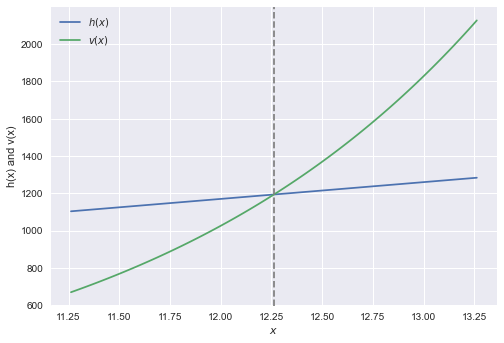

In [18]:
from copia.plot import minsample_diagnostic_plot
minsample_diagnostic_plot(abundance, diagn)
plt.savefig('../outputs/optimization.pdf');

## Single-assemblage plots

Many plotting functions are available. First, we cover those that are meant to be applied to a single assemblage.

#### Species accumulation
A species accumulation curve can be calculated as follows:

In [19]:
from copia.richness import species_accumulation
accumulation = species_accumulation(abundance, max_steps=4000, n_iter=10)
accumulation

100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


{'richness': array([  1.        ,   1.97511002,   2.92667983, ..., 152.41811178,
        152.41811222, 152.41811267]),
 'lci': array([  1.        ,   1.96799473,   2.90638295, ..., 119.56849343,
        119.56849235, 119.56849127]),
 'uci': array([  1.        ,   1.98086177,   2.94318192, ..., 183.08086059,
        183.08086951, 183.0808784 ]),
 'std': array([8.74387920e-13, 4.13195515e-03, 1.18284965e-02, ...,
        1.87510987e+01, 1.87511012e+01, 1.87511037e+01]),
 'bootstrap': array([[  1.        ,   1.9747493 ,   2.92551764, ..., 141.64977697,
         141.64977593, 141.6497749 ],
        [  1.        ,   1.98117019,   2.94411396, ..., 150.42889663,
         150.42889555, 150.42889447],
        [  1.        ,   1.96883342,   2.9085859 , ..., 163.92436778,
         163.92436775, 163.92436771],
        ...,
        [  1.        ,   1.97979944,   2.93997154, ..., 132.16844253,
         132.16844145, 132.16844037],
        [  1.        ,   1.97633648,   2.93098229, ..., 168.26821535,

To plot the result, use:

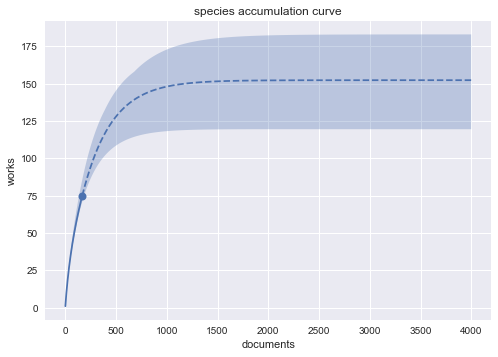

In [20]:
from copia.plot import accumulation_curve
accumulation_curve(abundance, accumulation,
                   xlabel='documents', ylabel='works',
                   title='species accumulation curve')
plt.savefig('../outputs/accumul.pdf')

Adding the distribution of the minsample estimate (on the second axis), can be done like so:

100%|██████████| 1000/1000 [00:01<00:00, 785.64it/s]


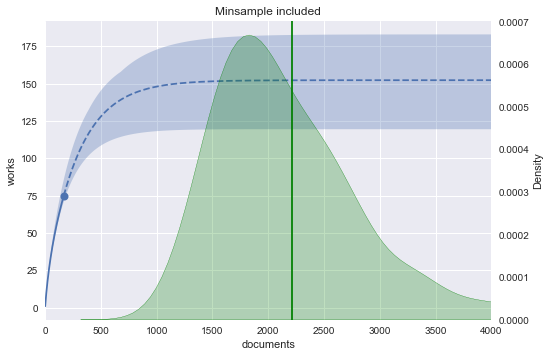

In [21]:
from copia.richness import diversity
minsample_est = diversity(abundance, method='minsample', 
                          solver='fsolve', CI=True)
accumulation_curve(abundance, accumulation, title='Minsample included',
                   xlabel='documents', ylabel='works',
                   minsample=minsample_est, xlim=(0, 4000))
plt.savefig('../outputs/accumul2.pdf')

#### Densities

To visualize the density of a diversity estimate, you should first obtain the result of a bootstrap:

100%|██████████| 1000/1000 [00:00<00:00, 2120.94it/s]


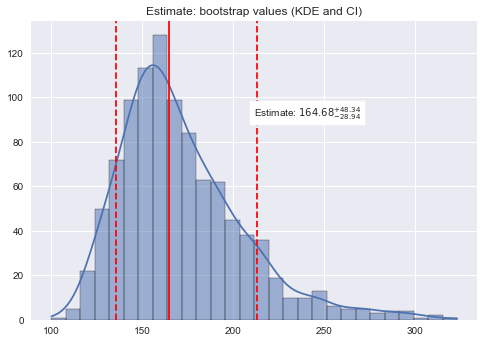

In [22]:
from copia.plot import density
estimate = diversity(abundance, method='iChao1', CI=True)
density(estimate);
plt.savefig('../outputs/dens1.pdf')

Adding the empirical richness, goes like this:

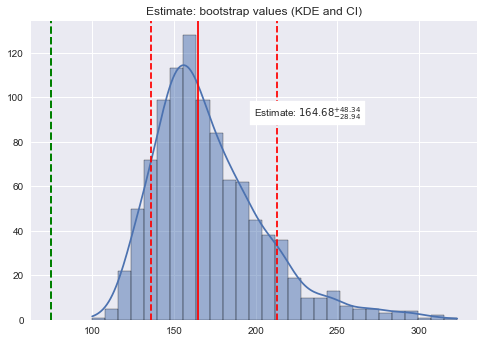

In [23]:
empirical = diversity(abundance, method='empirical')
density(estimate, empirical);
plt.savefig('../outputs/dens2.pdf')

We provide a utility to obtain these estimates as "survival ratios" (or sample completeness at order=1), bounded between 0 and 1. The result can also be plotted using `density()`:

100%|██████████| 1000/1000 [00:00<00:00, 1896.36it/s]


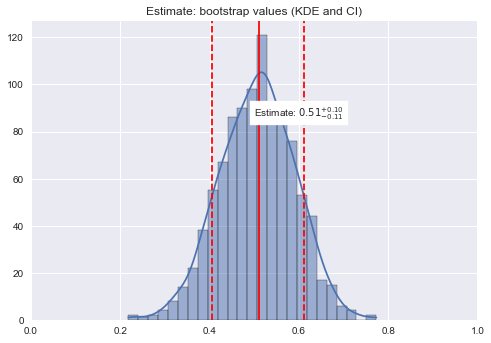

In [24]:
from copia.utils import survival_ratio
survival = survival_ratio(abundance, method='chao1')
density(survival, xlim=(0, 1));
plt.savefig('../outputs/surv.pdf')

#### Hill numbers

Hill numbers for an assemblage can be easily obtained:

In [25]:
from copia.hill import hill_numbers
emp, est = hill_numbers(abundance, n_iter=10)
print(est)

100%|██████████| 10/10 [00:00<00:00, 17.35it/s]

{'richness': array([152.41824044, 145.82184658, 138.9330011 , 131.79395357,
       124.4625506 , 117.01219443, 109.53008596, 102.1134491 ,
        94.86379396,  87.87976983,  81.24964105,  75.04468687,
        69.31472003,  64.08642992,  59.36455991,  55.13529736,
        51.3709035 ,  48.03460009,  45.08496789,  42.47944496,
        40.17681159,  38.13874942,  36.3306601 ,  34.72195033,
        33.28596725,  31.99972891,  30.84355249,  29.80064845,
        28.85672191,  27.99960392,  27.21892313]), 'lci': array([117.15885628, 113.44483476, 109.5461644 , 105.46607004,
       101.21361806,  96.80630904,  92.27260721,  87.65347458,
        83.00188988,  78.27568791,  72.30583629,  65.7927856 ,
        59.66212084,  54.10827258,  49.06106928,  44.53091014,
        40.55811713,  37.09032342,  34.0707311 ,  31.44291008,
        29.15388641,  27.15581494,  25.40662436,  23.8699966 ,
        22.51496536,  21.31533324,  20.24903455,  19.29751723,
        18.44518121,  17.67888788,  16.98754253

By default, `copia.hill.hill_numbers()` returns two dicts, one with the Hill curve for the empirical data, one for the estimated richnesses. These can be jointly passed to `copia.plot.hill_plot()` to obtain the following visualization:

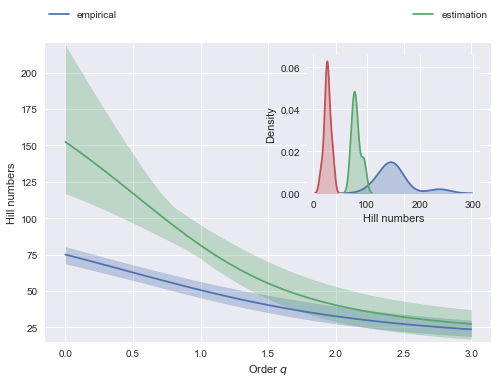

In [26]:
import copia.plot as plot
plot.hill_plot(emp, est);

## Multi-assemblage plots

We also provide a number of plotting functions to compare multiple assemblages. Consider the following two example assemblages (already abundance data) from the "spider" data in the [iNext package](https://cran.r-project.org/web/packages/iNEXT/vignettes/Introduction.html):

In [27]:
assemblages = {}
assemblages['girdled'] = [46, 22, 17, 15, 15, 9, 8, 6, 6, 4, 2, 2,
                          2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
assemblages['logged'] = [88, 22, 16, 15, 13, 10, 8, 8, 7, 7, 7, 5,
                          4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1,
                          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Obtain bootstrapped survival estimates and convert them to survival ratios:

In [28]:
survival = {}
for category, assemblage in assemblages.items():
    survival[category] = survival_ratio(assemblage, method='chao1')

100%|██████████| 1000/1000 [00:00<00:00, 1930.31it/s]


We can jointly visualize the estimate collected in the resulting dict using `copia.plot.multi_kde()`:

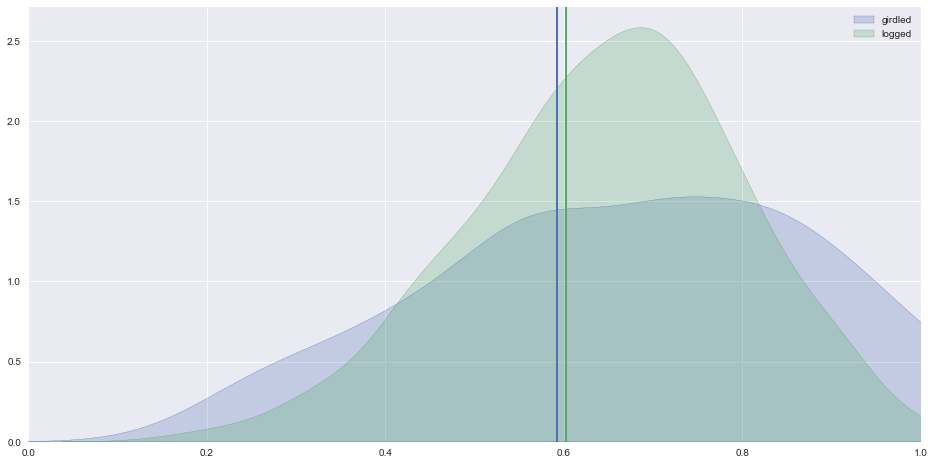

In [29]:
from copia.plot import multi_kde
multi_kde(survival);
plt.savefig('../outputs/multi_kde.pdf')

Alternatively, visualize the estimates with error bars:

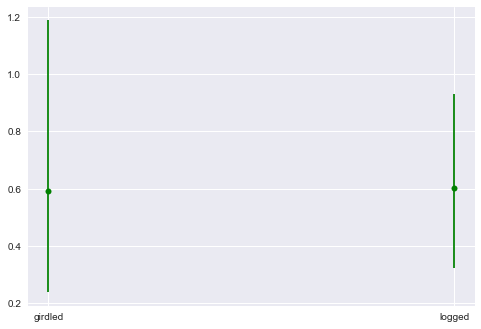

In [30]:
from copia.plot import survival_errorbar
survival_errorbar(survival);
plt.savefig('../outputs/error_bar.pdf')

Finally, evenness curves are useful to compare assemblages in a single plot. First, obtain the (estimated) Hill profiles for the assemblages:

In [31]:
hill_est = {}
for lang, assemblage in assemblages.items():
    _, est = hill_numbers(assemblage, n_iter=10)
    hill_est[lang] = est

100%|██████████| 10/10 [00:00<00:00, 13.34it/s]


Next, convert the Hill profile into an evenness profile:

In [32]:
from copia.utils import evenness
evennesses = {l:evenness(hill_est[l]) for l in hill_est}

Finally, produce a joint plot with the resulting profiles:

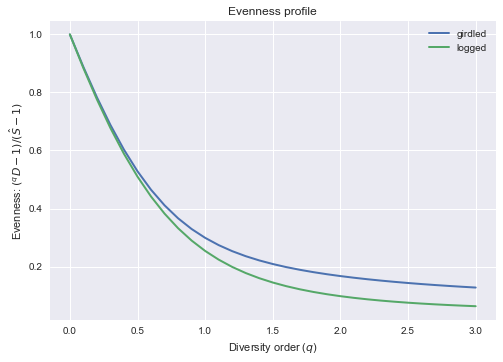

In [33]:
from copia.plot import evenness_plot
evenness_plot(evennesses);
plt.savefig('../outputs/evenness.pdf')